In [1]:
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from geomodel import geoModel, epoch, geoDataSet
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
sns.set_theme()

/Users/btb/.virtualenvs/geospatial/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
batch_size = 1024

dataset = geoDataSet("data/labels.npy","data/features.npy")
number_samples = len(dataset)

train_dataset, test_dataset = random_split(dataset, [round(number_samples*0.8),number_samples-round(number_samples*0.8)])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

unique_points = dataset.label_count
context_size = dataset.context_size
embedding_dimension = 10
model = geoModel(unique_points+1, embedding_dimension, context_size)

loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [5]:
losses = ()
for i in range(0,50):
    losses = epoch(model, loss_function, optimizer, train_dataloader, test_dataloader=test_dataloader, model_save_path="model_save/model.pt")

loss:  1.153594 | time 0.018862(s) | Batch [    0/    5]
epoch 100 done | loss 5.581754 | time 0.124764(s)
epoch 100 | test loss 2.459633
loss:  1.062793 | time 0.012966(s) | Batch [    0/    5]
epoch 101 done | loss 5.590086 | time 0.126628(s)
epoch 101 | test loss 2.497139
loss:  1.094131 | time 0.015555(s) | Batch [    0/    5]
epoch 102 done | loss 5.527880 | time 0.124500(s)
epoch 102 | test loss 2.472943
loss:  1.153296 | time 0.012078(s) | Batch [    0/    5]
epoch 103 done | loss 5.485688 | time 0.115195(s)
epoch 103 | test loss 2.306834
loss:  1.136294 | time 0.011483(s) | Batch [    0/    5]
epoch 104 done | loss 5.475745 | time 0.110847(s)
epoch 104 | test loss 2.706440
loss:  1.100827 | time 0.010597(s) | Batch [    0/    5]
epoch 105 done | loss 5.488540 | time 0.114102(s)
epoch 105 | test loss 2.370348
loss:  1.044398 | time 0.009890(s) | Batch [    0/    5]
epoch 106 done | loss 5.471078 | time 0.102283(s)
epoch 106 | test loss 2.488449
loss:  1.035801 | time 0.012711(s)

<AxesSubplot:xlabel='Epoch', ylabel='Test Loss'>

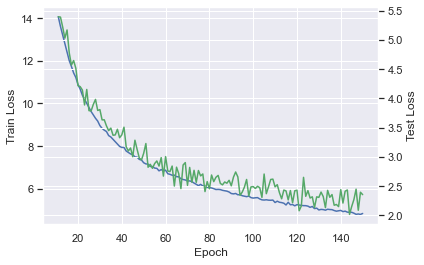

In [13]:
loss_df = pd.DataFrame({"Epoch":[i+1 for i in range(0,len(losses[0]))],"Train Loss":losses[0],"Test Loss":losses[1]})
loss_df["delta"] = loss_df["Train Loss"] - loss_df["Test Loss"]
sns.lineplot(data=loss_df[10:],x="Epoch",y="Train Loss")
ax2 = plt.twinx()
sns.lineplot(data=loss_df[10:],x="Epoch",y="Test Loss", color="g", ax=ax2)

In [10]:
model.predict(dataset[1:4]["context"]), dataset[1:4]["target"]

(tensor([43, 42, 43]), tensor([43, 42, 43]))

In [11]:
import folium

In [15]:
locations = pd.read_csv("data/points.csv")
locations.shape

(82, 3)

In [36]:
location_index = {}

for i, location in locations.iterrows():
    location_index[int(location[0])] = [location[1],location[2]]

    

# Look at 5000

In [71]:
target_pred = int(model.predict(dataset[5000]["context"]))
context = [int(i) for i in dataset[5000]["context"]]
target_actual = int(dataset[5000]["target"])

context_ll = []
for c in context:
    context_ll.append(location_index[c])

actual_ll = location_index[target_actual]
pred_ll = location_index[target_pred]
m = folium.Map(location=pred_ll,zoom_start=15)

for i,ll in enumerate(context_ll):
    # folium.CircleMarker((ll[0],ll[1]),radius=3,tooltip=i).add_to(m)
    folium.Circle((ll[0],ll[1]), radius=30, color="forestgreen",tooltip=i).add_to(m)

folium.Circle(actual_ll, radius=30, color="red",tooltip="actual").add_to(m)
folium.Circle(pred_ll, radius=15, color="blue",tooltip="predicted").add_to(m)


m